In [28]:
conda install lightgbm

Solving environment: done

## Package Plan ##

  environment location: /opt/homebrew/anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    lightgbm-3.3.5             |  py310h313beb8_0         979 KB
    ------------------------------------------------------------
                                           Total:         979 KB

The following NEW packages will be INSTALLED:

  lightgbm           pkgs/main/osx-arm64::lightgbm-3.3.5-py310h313beb8_0 



                                                                                
Preparing transaction: done
Verifying transaction: - WARNING conda.core.path_actions:verify(1093): Unable to create environments file. Path not writable.
  environment location: /Users/sunflower/.conda/environments.txt

done
Executing transaction: done

Note: you may need to restart the kernel to use updated package

In [33]:
pip install scalecast pandas_datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<AxesSubplot: >

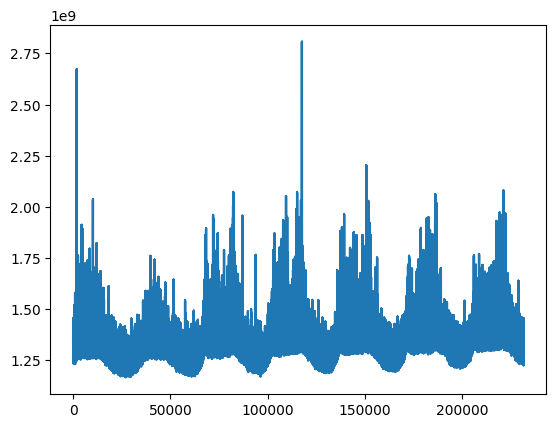

In [22]:

import pandas as pd
data = pd.read_csv('../data/cpu_memory_usage_v1.csv', header=0)
data = data.loc[:, ['time', 'memory_working_set_bytes']]
data['memory_working_set_bytes'].plot()

In [75]:
data

,time,memory_working_set_bytes
0,1678492800000000000,1337585664
1,1678492800000000000,1361653760
2,1678492800000000000,1285890048
3,1678492800000000000,1254232064
4,1678492800000000000,1294434304
...,...,...
231630,1679071890000000000,1313955840
231631,1679071890000000000,1338773504
231632,1679071890000000000,1415725056
231633,1679071890000000000,1453850624


In [76]:

train_df = data[0:150000]
test_df = data[150000:]

<AxesSubplot: xlabel='Date', ylabel='Values'>

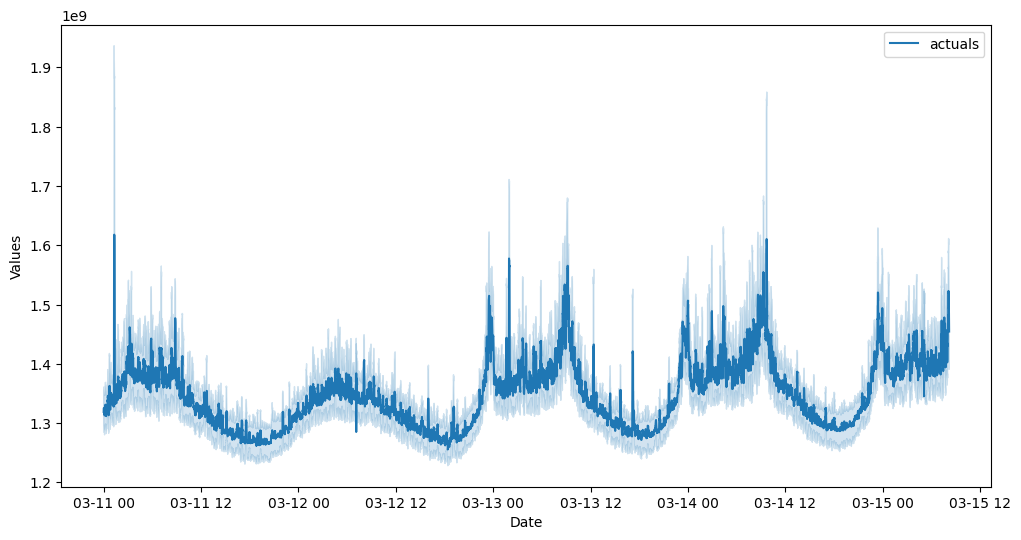

In [77]:
from scalecast.Forecaster import Forecaster
import matplotlib.pyplot as plt
import pandas_datareader as pdr

f = Forecaster(y=train_df['memory_working_set_bytes'], current_dates=train_df['time'])
f.plot()

/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


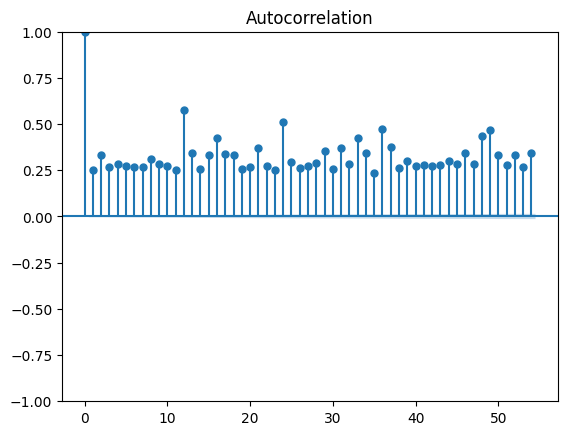

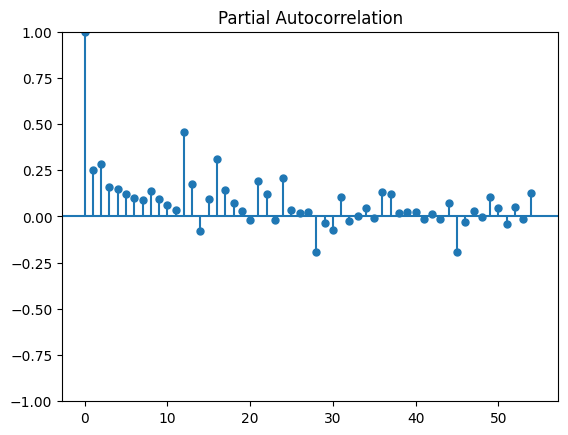

In [36]:
f.plot_acf()
f.plot_pacf()
plt.show()

/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


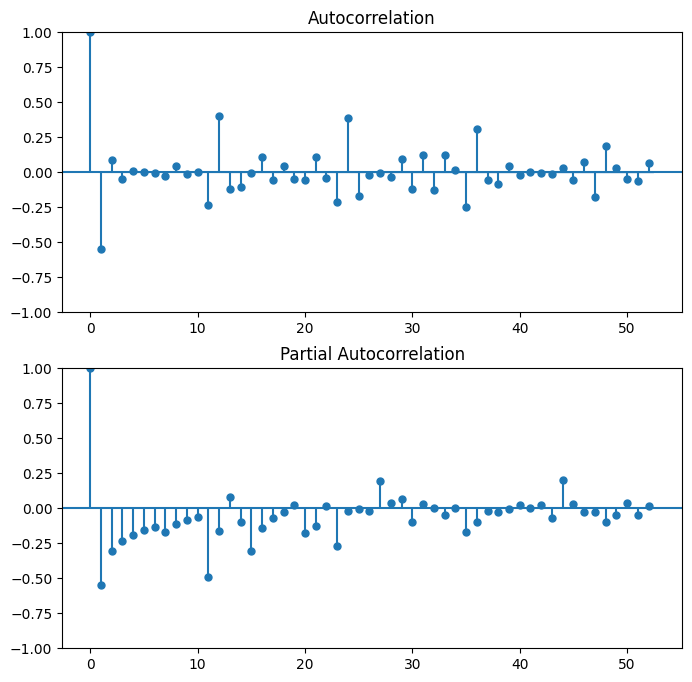

In [78]:
fig, ax = plt.subplots(2,1, figsize=(8,8)) # 차분 1회 -> d = 1
plot_acf(train_df['memory_working_set_bytes'].diff().dropna(), ax[0]) # 시차 2 이후에 0으로 가까워 짐
plot_pacf(train_df['memory_working_set_bytes'].diff().dropna(), ax[1]) # 시차 2이후에 0으로 가까워 짐
plt.show() # AR(2), MA(2), ARMA(2,2)

In [79]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = ARIMA(train_df['memory_working_set_bytes'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                                  SARIMAX Results                                   
Dep. Variable:     memory_working_set_bytes   No. Observations:               150000
Model:                       ARIMA(2, 1, 2)   Log Likelihood            -2950640.931
Date:                      Tue, 04 Apr 2023   AIC                        5901291.863
Time:                              19:50:16   BIC                        5901341.455
Sample:                                   0   HQIC                       5901306.644
                                   - 150000                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0594      0.002   -446.628      0.000      -1.064      -1.055
ar.L2         -0.0595      0.002    -25.101      0.000      -0.064      -0.055
ma.L

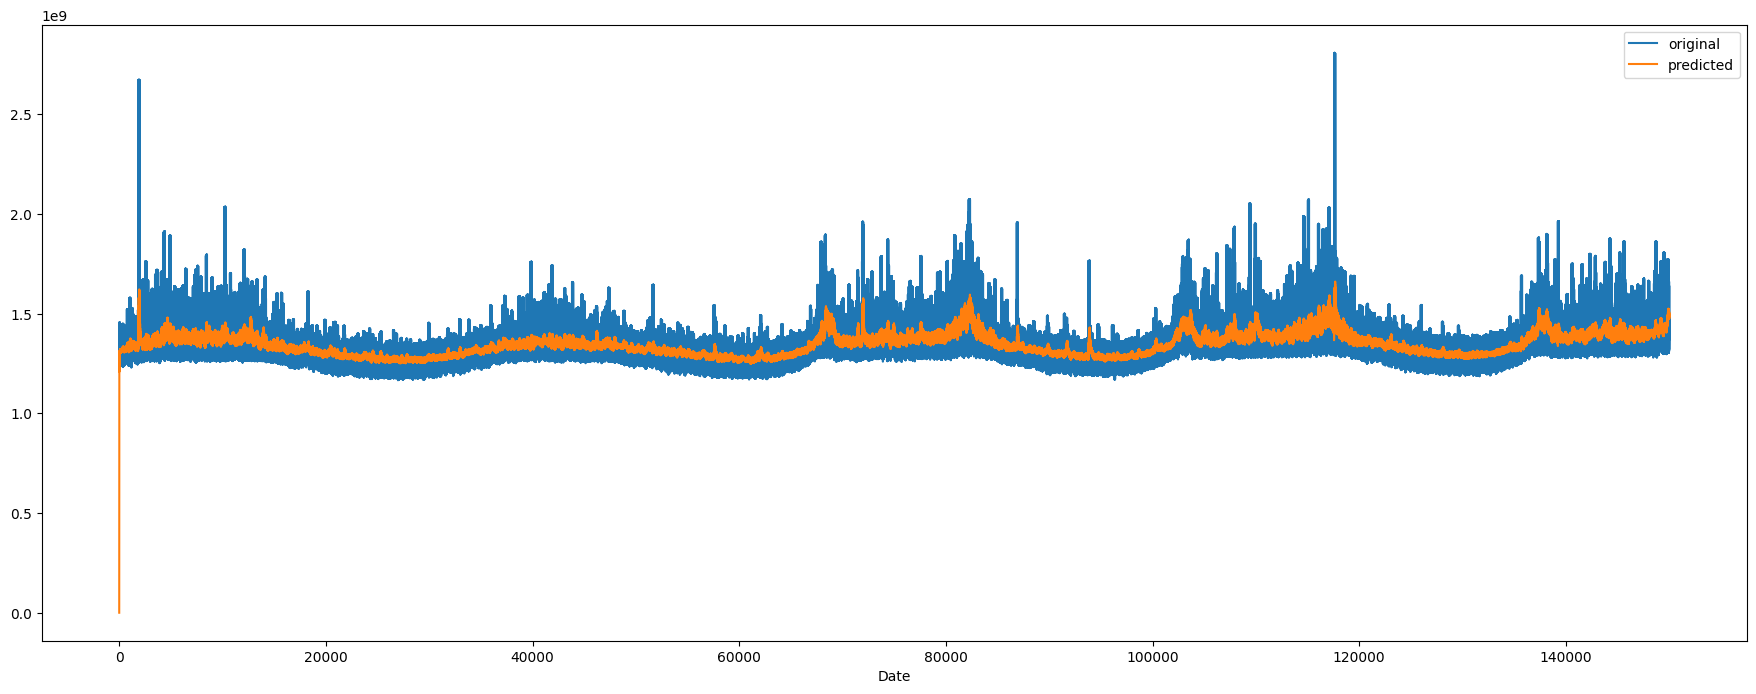

In [80]:
forecast = model_fit.predict(typ='levels')
plt.figure(figsize=(22,8))
plt.plot(train_df['memory_working_set_bytes'], label='original')
plt.plot(forecast, label='predicted')
plt.xlabel('Date')
plt.legend()
plt.show()

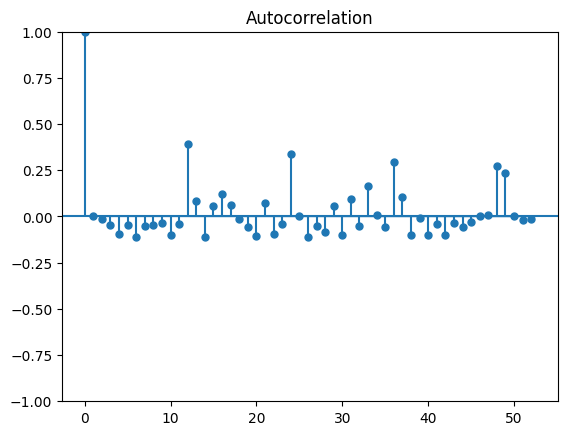

In [81]:
plot_acf(model_fit.resid)
plt.show()

In [65]:
from itertools import product

p = range(0,3)
d = [1]
q = range(0,3)
pdq = list(product(p, d, q))

aic = []
for i in pdq:
    model = ARIMA(data['memory_working_set_bytes'], order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
    
# Search optimal parameters
optimal = [(pdq[i],j) for i, j in enumerate(aic) if j == min(aic)]
optimal

ARIMA: (0, 1, 0) >> AIC : 30355211.23
ARIMA: (0, 1, 1) >> AIC : 9127094.98
ARIMA: (0, 1, 2) >> AIC : 9122297.78
ARIMA: (1, 1, 0) >> AIC : 9213219.98
ARIMA: (1, 1, 1) >> AIC : 9124731.59
ARIMA: (1, 1, 2) >> AIC : 9118704.02
ARIMA: (2, 1, 0) >> AIC : 9190412.89
ARIMA: (2, 1, 1) >> AIC : 9124597.01
ARIMA: (2, 1, 2) >> AIC : 9117624.9


[((2, 1, 2), 9117624.9)]

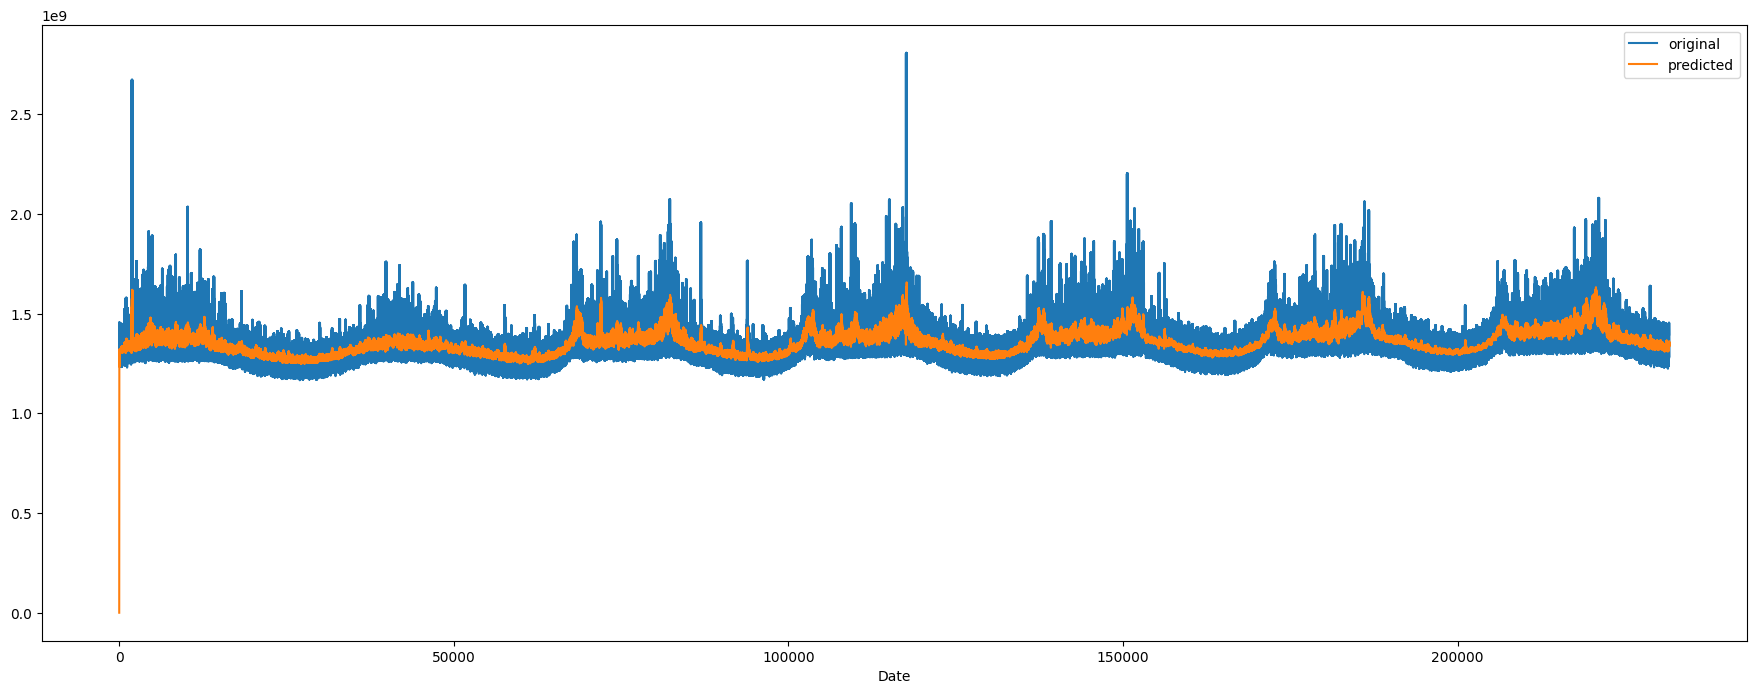

In [67]:
predict = model_fit.predict(typ='levels')
plt.figure(figsize=(22,8))
plt.plot(train_df['memory_working_set_bytes'], label='original')
plt.plot(predict, label='predicted')
plt.xlabel('Date')
plt.legend()
plt.show()

In [83]:
forecast = model_fit.forecast(steps=1)
print(forecast)

150000    1.499417e+09
dtype: float64


In [84]:
result = model_fit.get_forecast(steps = len(test_df.index), alpha = 0.05).summary_frame()
result

memory_working_set_bytes,mean,mean_se,mean_ci_lower,mean_ci_upper
150000,1.499417e+09,9.256275e+07,1.317997e+09,1.680836e+09
150001,1.474118e+09,9.264519e+07,1.292537e+09,1.655699e+09
150002,1.493278e+09,9.267217e+07,1.311644e+09,1.674912e+09
150003,1.474486e+09,9.268377e+07,1.292829e+09,1.656142e+09
150004,1.493254e+09,9.270358e+07,1.311558e+09,1.674950e+09
...,...,...,...,...
231630,1.483871e+09,4.947415e+08,5.141956e+08,2.453547e+09
231631,1.483871e+09,4.947444e+08,5.141896e+08,2.453552e+09
231632,1.483871e+09,4.947474e+08,5.141841e+08,2.453558e+09
231633,1.483871e+09,4.947503e+08,5.141782e+08,2.453564e+09


In [85]:
fc = tuple(result['mean'].values) # 예측값
se = tuple(result['mean_se'].values) # 표준오차
lower_coef = tuple(result['mean_ci_lower'].values) # 신뢰구간 최소
upper_coef = tuple(result['mean_ci_upper'].values) # 신뢰구간 최대

# 예측값 인덱스 넣기
fc_data = pd.Series(fc, index = test_df.index)

# 신뢰구간 인덱스 넣기
lower_data = pd.Series(lower_coef, index = test_df.index)
upper_data = pd.Series(upper_coef, index = test_df.index )

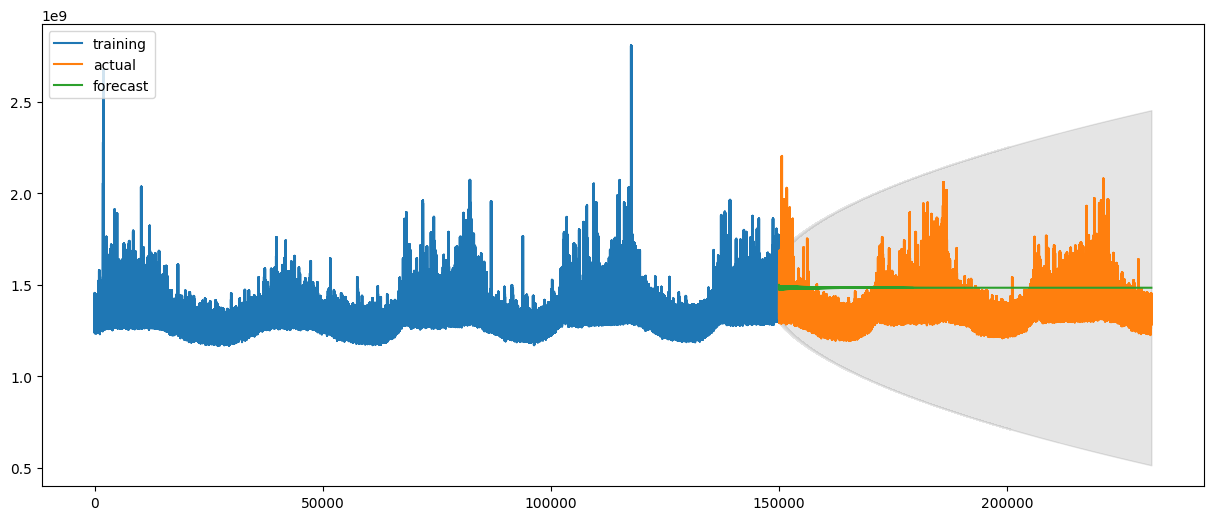

In [88]:
#시각화 
plt.figure(figsize =(15, 6))
plt.plot(train_df['memory_working_set_bytes'], label = 'training')
plt.plot(test_df['memory_working_set_bytes'], label = 'actual')
plt.plot(fc_data, label = 'forecast')
plt.fill_between(test_df.index, lower_data, upper_data, color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.show()